<a href="https://www.kaggle.com/code/ravaghi/s04e12-insurance-premium-prediction-autogluon?scriptVersionId=211252723" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports and configs

In [1]:
!pip install -q autogluon.tabular ray==2.10.0 scikit-learn==1.5.2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.15.1 requires botocore<1.35.24,>=1.35.16, but you have botocore 1.29.165 which is incompatible.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.3 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.


In [2]:
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import shutil
import os

warnings.filterwarnings('ignore')

In [3]:
class CFG:
    train_path = '/kaggle/input/playground-series-s4e12/train.csv'
    test_path = '/kaggle/input/playground-series-s4e12/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s4e12/sample_submission.csv'
    
    target = 'Premium Amount'
    n_folds = 5
    seed = 42
    time_limit = 3600 * 11

# Loading data and predefining folds

In [4]:
train = pd.read_csv(CFG.train_path, index_col='id')
test = pd.read_csv(CFG.test_path, index_col='id')

train[CFG.target] = np.log1p(train[CFG.target])

In [5]:
kf = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = kf.split(train, train[CFG.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, 'fold'] = i

# Fitting the predictor

In [6]:
predictor = TabularPredictor(
    problem_type='regression',
    eval_metric='rmse',
    label=CFG.target,
    groups='fold',
    verbosity=2
)

No path specified. Models will be saved in: "AutogluonModels/ag-20241204_191131"


In [7]:
predictor.fit(
    train_data=train,
    time_limit=CFG.time_limit,
    presets='best_quality',
    excluded_model_types=['KNN']
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       29.75 GB / 31.35 GB (94.9%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdout validation data is used to detect stacked 

(_ray_fit pid=498) [1000]	valid_set's rmse: 1.05012
(_ray_fit pid=496) [1000]	valid_set's rmse: 1.05025 [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(_ray_fit pid=497) [2000]	valid_set's rmse: 1.04899
(_ray_fit pid=499) [2000]	valid_set's rmse: 1.04803
(_ray_fit pid=496) [2000]	valid_set's rmse: 1.04992
(_ray_fit pid=499) [3000]	valid_set's rmse: 1.04805
(_ray_fit pid=608) [1000]	valid_set's rmse: 1.04993


(_dystack pid=173) 	-1.0493	 = Validation score   (-root_mean_squared_error)
(_dystack pid=173) 	1079.97s	 = Training   runtime
(_dystack pid=173) 	511.02s	 = Validation runtime
(_dystack pid=173) Fitting model: LightGBM_BAG_L1 ... Training model for up to 5470.72s of the 8766.30s of remaining time.
(_dystack pid=173) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=2.75%)
(_dystack pid=173) 	-1.0457	 = Validation score   (-root_mean_squared_error)
(_dystack pid=173) 	147.03s	 = Training   runtime
(_dystack pid=173) 	37.86s	 = Validation runtime
(_dystack pid=173) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 5314.99s of the 8610.57s of remaining time.
(_dystack pid=173) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=173) 	Fitting 5 child models (S1F1 - S1F5) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=2.83%)
(_ray_fit

In [8]:
predictor.leaderboard(silent=True).style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-1.044612,root_mean_squared_error,1123.858671,28987.255695,0.043360,3.561803,3,True,18
1,LightGBM_BAG_L2,-1.044781,root_mean_squared_error,1041.255424,19676.435158,14.113652,106.836198,2,True,11
2,XGBoost_BAG_L2,-1.044834,root_mean_squared_error,1037.967020,19939.066983,10.825247,369.468022,2,True,15
3,CatBoost_BAG_L2,-1.044884,root_mean_squared_error,1028.760689,20848.169782,1.618916,1278.570822,2,True,13
4,LightGBMXT_BAG_L2,-1.044955,root_mean_squared_error,1058.856835,19740.580858,31.715062,170.981898,2,True,10
5,WeightedEnsemble_L2,-1.045071,root_mean_squared_error,167.237353,16706.787104,0.047279,2.132384,2,True,9
6,NeuralNetFastAI_BAG_L2,-1.045321,root_mean_squared_error,1049.728900,20062.333453,22.587127,492.734492,2,True,14
7,LightGBM_BAG_L1,-1.045708,root_mean_squared_error,60.206178,221.109032,60.206178,221.109032,1,True,2
8,XGBoost_BAG_L1,-1.046338,root_mean_squared_error,12.992201,353.165029,12.992201,353.165029,1,True,7
9,CatBoost_BAG_L1,-1.047025,root_mean_squared_error,3.634614,7530.852005,3.634614,7530.852005,1,True,4


# Visualizing the ensemble weights

In [9]:
def get_ensemble_weights(predictor):
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
    return ensemble_weights

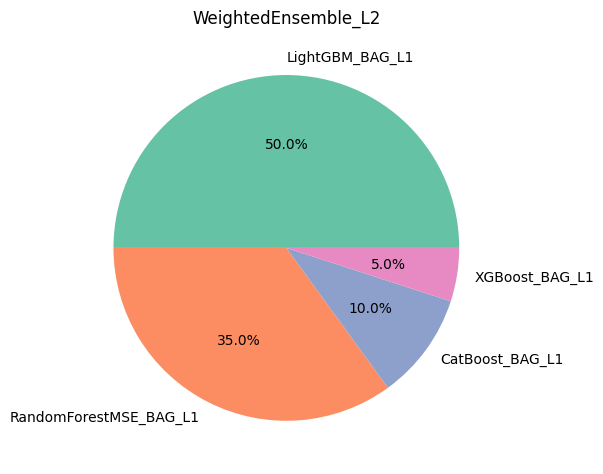

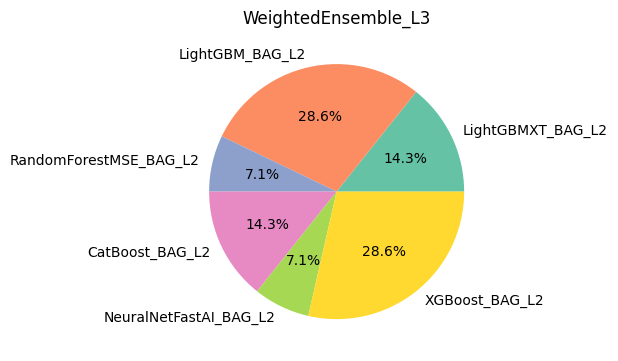

In [10]:
ensemble_weights = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(6, 6))
    plt.pie(value.values(), labels=value.keys(), autopct='%1.1f%%', colors=sns.color_palette('Set2', len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

# Collecting and saving OOF files

In [11]:
def save_preds(preds, cv_score, name, type, is_ensemble):
    base_path = 'oof_preds' if type == 'oof' else 'test_preds'
    base_path = '.' if is_ensemble else base_path
    with open(f'{base_path}/{name}_{type}_preds_{cv_score:.6f}.pkl', 'wb') as f:
        pickle.dump(np.expm1(preds), f)

def save_submission(test_preds, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = np.expm1(test_preds)
    sub.to_csv(f'sub_autogluon_{score:.6f}.csv', index=False)
    
os.makedirs('oof_preds', exist_ok=True)
os.makedirs('test_preds', exist_ok=True)

In [12]:
oof_preds = {}
test_preds = {}

In [13]:
best_model = predictor.model_best
test_preds = predictor.predict_multi(test)
for model in predictor.model_names():
    model_oof_preds = predictor.predict_oof(model).values
    model_test_preds = test_preds[model].values
    
    cv_score = root_mean_squared_error(train[CFG.target], np.maximum(model_oof_preds, 0))
    if model != best_model:
        save_preds(model_oof_preds, cv_score, model, 'oof', False)
        save_preds(model_test_preds, cv_score, model, 'test', False)
    else:
        save_preds(model_oof_preds, cv_score, model, 'oof', True)
        save_preds(model_test_preds, cv_score, model, 'test', True)
        save_submission(model_test_preds, cv_score)
        
    oof_preds[model] = model_oof_preds
    test_preds[model] = model_test_preds

# Visualizing the results

In [14]:
scores = {}
split = KFold(n_splits=CFG.n_folds, shuffle=False).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        fold_score = root_mean_squared_error(train.loc[val_index, CFG.target], np.maximum(oof_preds[model][val_index], 0))
        if model not in scores:
            scores[model] = []
        scores[model].append(fold_score)

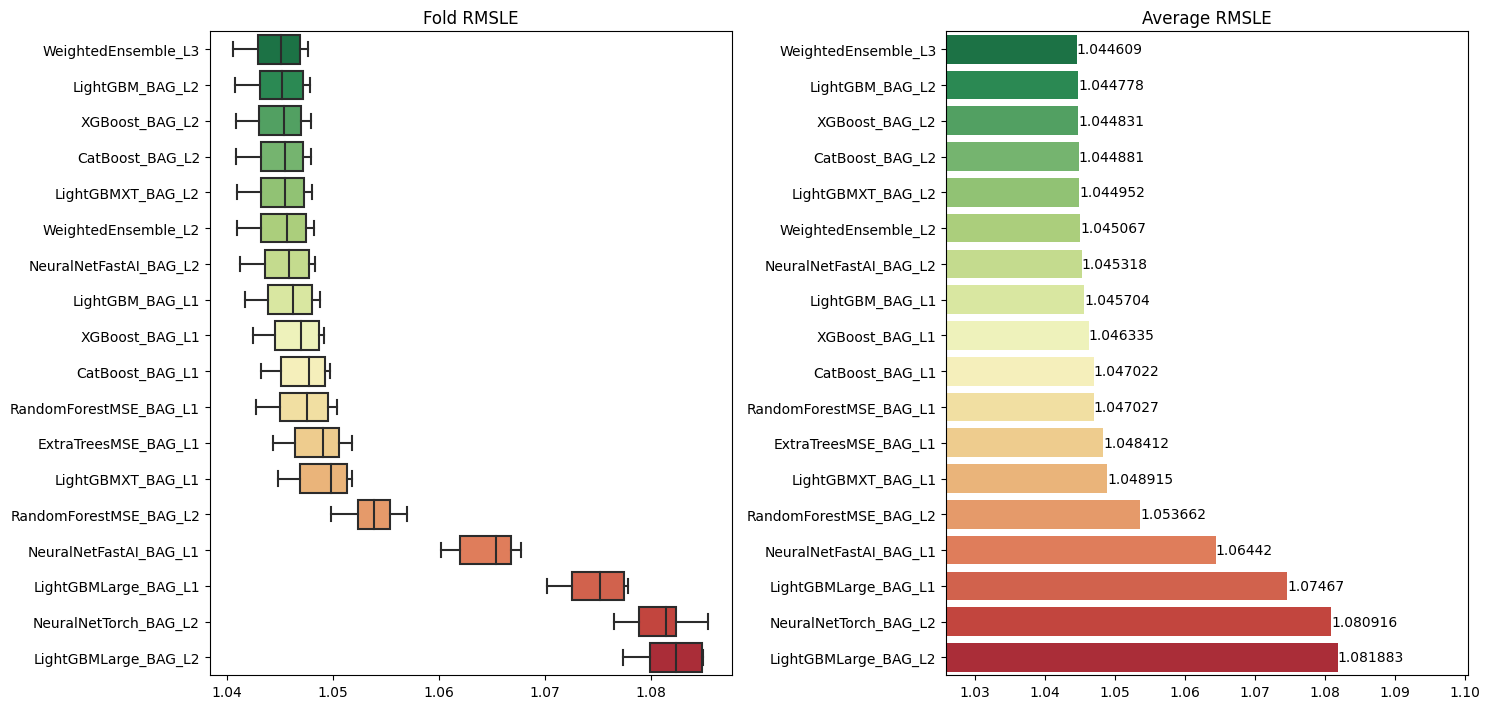

In [15]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.4))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', palette='RdYlGn_r')
axs[0].set_title('Fold RMSLE')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette='RdYlGn_r')
axs[1].set_title('Average RMSLE')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()

In [16]:
shutil.rmtree("AutogluonModels")